In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from tqdm import tqdm
import seaborn
import torch
import torch.nn as nn
BILICOUGH_ROOT = "G:/DATAS-Medical/BILIBILICOUGH/"

# 从mp4中提取wav音频

In [13]:
names = ["金_属_音_咳_嗽","剧烈的咳嗽。","女孩感冒哮喘发作","四个常见咳嗽声音最后一个要重视_听一下你属于哪一种","我咳嗽的样子", "小朋友哮喘发作（看着好痛苦）"]
for name in names:
    filename = BILICOUGH_ROOT + name + ".mp4"
    outname = BILICOUGH_ROOT + name + ".wav"
    os.system("ffmpeg -i {} -f wav -ar 44100 {}".format(filename, outname))

In [17]:
file_list = []
for item in os.listdir(BILICOUGH_ROOT):
    if item[-3:] == "ass":
        file_list.append(item)
name_mapper = open(BILICOUGH_ROOT + "filename2index.txt", 'w')
for idx, item in enumerate(file_list):
    print(BILICOUGH_ROOT+item)
    name_mapper.write("bilicough_{},".format(("00"+str(idx))[-3:])+item[:-4]+"\n")
name_mapper.close()

G:/DATAS-Medical/BILIBILICOUGH/【噪音反击】男人的咳嗽声（1）.ass
G:/DATAS-Medical/BILIBILICOUGH/一个患上百日咳的女孩.ass
G:/DATAS-Medical/BILIBILICOUGH/剧烈的咳嗽。.ass
G:/DATAS-Medical/BILIBILICOUGH/咳嗽吐痰的声音 Coughing and spitting sound.ass
G:/DATAS-Medical/BILIBILICOUGH/咳嗽声这样的，小心百日咳.ass
G:/DATAS-Medical/BILIBILICOUGH/喘鸣音、鸡鸣音，这些都代表什么疾病？.ass
G:/DATAS-Medical/BILIBILICOUGH/四个常见咳嗽声音最后一个要重视  听一下你属于哪一种.ass
G:/DATAS-Medical/BILIBILICOUGH/女孩感冒哮喘发作.ass
G:/DATAS-Medical/BILIBILICOUGH/小朋友哮喘发作（看着好痛苦）.ass
G:/DATAS-Medical/BILIBILICOUGH/得了肺炎是什么感觉？看看这个就知道了.ass
G:/DATAS-Medical/BILIBILICOUGH/患了百日咳的女孩.ass
G:/DATAS-Medical/BILIBILICOUGH/患百日咳的小孩.ass
G:/DATAS-Medical/BILIBILICOUGH/我咳嗽的样子.ass
G:/DATAS-Medical/BILIBILICOUGH/滚蛋吧 肺癌君 听懂咳嗽的声音.ass
G:/DATAS-Medical/BILIBILICOUGH/百日咳.ass
G:/DATAS-Medical/BILIBILICOUGH/第一视角哮喘夜间发作.ass
G:/DATAS-Medical/BILIBILICOUGH/这样的咳嗽声音要小心，这样的面色要小心.ass
G:/DATAS-Medical/BILIBILICOUGH/金 属 音 咳 嗽.ass
G:/DATAS-Medical/BILIBILICOUGH/鸡鸣样的百日咳到底怎么咳？.ass


# 读取整个音频并标注其咳嗽段

In [2]:
wavfin = open(BILICOUGH_ROOT + "filename2index.txt", 'r')
name_list = []
wavfin.readline()
line = wavfin.readline()
while line:
    name_list.append(line.strip())
    line = wavfin.readline()
print(name_list)

['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']


In [3]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res

def wav_plot(wavfile, label_list, idx=0):
    y, sr = librosa.load(BILICOUGH_ROOT + wavfile)
    print("sample rate:", sr)
    y_plt = np.array([])
    for item in label_list:
        st, en = int(min2sec(item[0])*sr), int(min2sec(item[1])*sr+1)
        print("st, en:", st, en)
        seg = y[st: en]
        y_plt = np.concatenate((y_plt, seg, np.zeros(8000)), axis=0)
    plt.figure(idx)
    plt.plot(y_plt)

bilicough_017.wav bilicough_017.ass
['0:00:00.37', '0:00:00.74', 'cough(dry)+noise']
['0:00:00.74', '0:00:01.98', 'noise1']
['0:00:01.98', '0:00:02.41', 'cough+noise']
['0:00:02.41', '0:00:02.85', 'cough(wet)+noise']
['0:00:02.85', '0:00:03.50', 'silence']
['0:00:03.50', '0:00:04.18', 'cough(wet)_breathe']
['0:00:04.45', '0:00:04.77', 'cough(wet)']
['0:00:04.86', '0:00:05.16', 'cough(wet)']
['0:00:05.44', '0:00:05.73', 'cough(wet)']
['0:00:05.73', '0:00:06.00', 'inhale']
['0:00:06.58', '0:00:07.08', 'whooping']
['0:00:07.97', '0:00:08.33', 'cough(whooping)']
['0:00:08.33', '0:00:08.65', 'cough(whooping)']
['0:00:08.65', '0:00:08.93', 'cough(whooping)']
['0:00:09.04', '0:00:09.32', 'cough(whooping)']
['0:00:09.57', '0:00:09.78', 'cough(whooping)']
['0:00:09.78', '0:00:10.11', 'whooping']
['0:00:10.56', '0:00:11.16', 'silence']
['0:00:11.16', '0:00:11.31', 'cough(metal)+noise']
sample rate: 22050
st, en: 8158 16318
st, en: 16317 43660
st, en: 43659 53141
st, en: 53140 62843
st, en: 62842

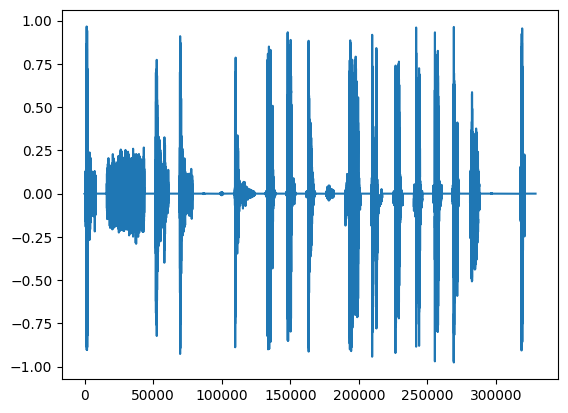

In [5]:
idx = 17
wavtest = name_list[idx] + ".wav"
asstest = name_list[idx] + ".ass"
print(wavtest, asstest)
assfin = open(BILICOUGH_ROOT + asstest, 'r', encoding="utf-8")
label_list = []
line = assfin.readline()
while line.strip()!="[Events]":
    line = assfin.readline()
    # print(line)
assfin.readline()
line = assfin.readline()
while line:
    # print(line)
    parts = line.split(',')
    if parts[9].strip() == "useless":
        pass
    else:
        label_list.append([parts[1], parts[2], parts[9].strip()])
    line = assfin.readline()
for item in label_list:
    print(item)
wav_plot(wavtest, label_list, idx)

### 批量绘图

In [ ]:
for idx, name in enumerate(name_list):
    wavtest = name_list[idx] + ".wav"
    asstest = name_list[idx] + ".ass"

    assfin = open(BILICOUGH_ROOT + asstest, 'r', encoding="utf-8")
    label_list = []
    line = assfin.readline()
    while line.strip()!="[Events]":
        line = assfin.readline()
        # print(line)
    assfin.readline()
    line = assfin.readline()
    while line:
        # print(line)
        parts = line.split(',')
        if parts[9].strip() == "useless":
            pass
        else:
            label_list.append([parts[1], parts[2], parts[9].strip()])
        line = assfin.readline()
    for item in label_list:
        print(item)
    
    wav_plot(wavtest, label_list, idx)

# 二分类及其标注
- 非咳嗽的标注：0，"useless", "silence", "noise"
- 咳嗽的标注：1，其他都是

### 第一步，读取所有的ass文件
- 查看标签有哪些，来自哪些文件
- 查看标签的个数
- 查看时长分布

In [1]:
wavfin = open("G:/DATAS-Medical/BILIBILICOUGH/filename2index.txt", 'r')
name_list = []
wavfin.readline()
line = wavfin.readline()
while line:
    name_list.append(line.strip())
    line = wavfin.readline()
print(name_list)

['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']


### 注意！此处有重要文件“bilicough_metainfo.csv”的创建和写入

In [6]:
print(name_list)
label_dict = dict()
label_names = ["breathe", "cough","clearthroat","exhale", "hum", "inhale","noise", "silence", "sniff","speech", "vomit","whooping"]
label_cnt = dict()
name2label = {"breathe":0, "cough":2,"clearthroat":1,"exhale":3, "hum":4, "inhale":5,"noise":6, "silence":7, "sniff":8,"speech":9, "vomit":10,"whooping":11}
# metainfo_file = open("G:/DATAS-Medical/BILIBILICOUGH/bilicough_metainfo.csv", 'w')
# metainfo_file.write("filename,labelfull,label\n")
for idx, name in enumerate(name_list):
    wavtest = name_list[idx] + ".wav"
    asstest = name_list[idx] + ".ass"
    assfin = open("G:/DATAS-Medical/BILIBILICOUGH/" + asstest, 'r', encoding="utf-8")
    label_list = []
    line = assfin.readline()
    while line.strip()!="[Events]":
        line = assfin.readline()
        # print(line)
    assfin.readline()
    line = assfin.readline()
    while line:
        # print(line)
        parts = line.split(',')
        lab_tmp = parts[9].strip()
        if lab_tmp == "useless":
            pass
        # if lab_tmp == "clearingthroat":
        #     print(name_list[idx])
        else:
            label_list.append([parts[1], parts[2], lab_tmp])
            if lab_tmp not in label_dict:
                label_dict[lab_tmp] = 1
            else:
                label_dict[lab_tmp] = label_dict.get(lab_tmp)+1
            
            label = None
            if lab_tmp[:3] == "hum":
                label = lab_tmp[:3]
            elif lab_tmp[:5] in ["cough", "noise", "sniff", "vomit"]:
                label = lab_tmp[:5]
            elif lab_tmp[:6] in ["inhale", "exhale", "speech"]:
                label = lab_tmp[:6]
            elif lab_tmp[:7] in ["breathe","silence"]:
                label = lab_tmp[:7]
            elif lab_tmp[:8] in ["whooping"]:
                label = lab_tmp[:8]
            elif lab_tmp[:11] in ["clearthroat"]:
                label = lab_tmp[:11]
            else:
                print(lab_tmp, name_list[idx])
                raise Exception("Unknown Class.")
                
            if label not in label_cnt:
                label_cnt[label] = 1
            else:
                label_cnt[label] = label_cnt.get(label)+1
            # metainfo_file.write("{},{},{},{}\n".format(name_list[idx], lab_tmp, label,name2label[label]))
        line = assfin.readline()
# metainfo_file.close()
# for item in label_list:
#     print(item)
print("标签分布：")
for k,v in label_dict.items():
    print("key:{},\tcount:{}".format(k,v))
print("---------------=============----------------")
for k,v in label_cnt.items():
    print("key:{},\tcount:{}".format(k,v))


['bilicough_000', 'bilicough_001', 'bilicough_002', 'bilicough_003', 'bilicough_004', 'bilicough_005', 'bilicough_006', 'bilicough_007', 'bilicough_008', 'bilicough_009', 'bilicough_010', 'bilicough_011', 'bilicough_012', 'bilicough_013', 'bilicough_014', 'bilicough_015', 'bilicough_016', 'bilicough_017', 'bilicough_018']
标签分布：
key:cough,	count:270
key:inhale,	count:72
key:whooping,	count:82
key:clearthroat,	count:15
key:sniff,	count:13
key:noise,	count:75
key:cough+speech,	count:10
key:cough(whooping),	count:194
key:speech,	count:41
key:whooping+speech,	count:5
key:silence,	count:11
key:hum,	count:19
key:breathe,	count:3
key:cough(unknown),	count:168
key:cough(asthma),	count:87
key:cough(laryngitis),	count:8
key:cough(dry),	count:14
key:cough(dry)+noise,	count:12
key:cough(wet),	count:15
key:cough(severe),	count:11
key:inhale(asthma),	count:19
key:vomit,	count:7
key:exhale,	count:31
key:vomit+speech,	count:2
key:exhale(asthma),	count:18
key:cough(pneumonia),	count:54
key:cough(bronchi

## 读取metainfo文件，创建不同任务的标注

In [20]:
metadf = pd.read_csv("G:/DATAS-Medical/BILIBILICOUGH/bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, encoding="ansi")
print(metadf)
newdf = metadf
newdf["binlab"] = newdf["label"].apply(lambda x:2 if x==2 else 0)
newdf

           filename        labelfull labelname  label
0     bilicough_000            cough     cough      2
1     bilicough_000            cough     cough      2
2     bilicough_000            cough     cough      2
3     bilicough_000            cough     cough      2
4     bilicough_000            cough     cough      2
...             ...              ...       ...    ...
1266  bilicough_018         whooping  whooping     11
1267  bilicough_018  cough(whooping)     cough      2
1268  bilicough_018  cough(whooping)     cough      2
1269  bilicough_018  cough(whooping)     cough      2
1270  bilicough_018           speech    speech      9

[1271 rows x 4 columns]


,filename,labelfull,labelname,label,binlab
0,bilicough_000,cough,cough,2,2
1,bilicough_000,cough,cough,2,2
2,bilicough_000,cough,cough,2,2
3,bilicough_000,cough,cough,2,2
4,bilicough_000,cough,cough,2,2
...,...,...,...,...,...
1266,bilicough_018,whooping,whooping,11,0
1267,bilicough_018,cough(whooping),cough,2,2
1268,bilicough_018,cough(whooping),cough,2,2
1269,bilicough_018,cough(whooping),cough,2,2


In [21]:
newdf.groupby("binlab").count()

,filename,labelfull,labelname,label
binlab,,,,
0,413,413,413,413
2,858,858,858,858


In [18]:
for ind, item in enumerate(metadf.itertuples()):
    print("key:{},\tcount:{}, {}, {}".format(ind, item[0], item[1], item[2]))

key:0,	count:0, bilicough_000, cough
key:1,	count:1, bilicough_000, cough
key:2,	count:2, bilicough_000, cough
key:3,	count:3, bilicough_000, cough
key:4,	count:4, bilicough_000, cough
key:5,	count:5, bilicough_000, cough
key:6,	count:6, bilicough_000, inhale
key:7,	count:7, bilicough_000, cough
key:8,	count:8, bilicough_000, cough
key:9,	count:9, bilicough_000, inhale
key:10,	count:10, bilicough_000, cough
key:11,	count:11, bilicough_000, cough
key:12,	count:12, bilicough_000, cough
key:13,	count:13, bilicough_000, cough
key:14,	count:14, bilicough_000, inhale
key:15,	count:15, bilicough_000, cough
key:16,	count:16, bilicough_000, cough
key:17,	count:17, bilicough_000, cough
key:18,	count:18, bilicough_000, cough
key:19,	count:19, bilicough_000, cough
key:20,	count:20, bilicough_000, cough
key:21,	count:21, bilicough_000, cough
key:22,	count:22, bilicough_000, inhale
key:23,	count:23, bilicough_000, cough
key:24,	count:24, bilicough_000, cough
key:25,	count:25, bilicough_000, cough
ke

# 通过滑动窗口截取数据片段

# 创建神经网络

In [13]:
a = np.array([1,2,43,])
b = np.array([5,76,8,])
c = np.array([4,8,6])
print(np.concatenate((np.array([]), a, b,c), axis=0))

[ 1.  2. 43.  5. 76.  8.  4.  8.  6.]
